In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import h5py
import json
import matplotlib as plt

/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
h5_dir_path = '../get_data/20240719/'
data_sheet_dir_path = '../get_data/data_sheets/'

In [3]:
image_id_res_df = pd.read_csv(data_sheet_dir_path+'image_id_res.csv')
crc_df = image_id_res_df[image_id_res_df['cancer']=='CRC']

In [4]:
HE_id=1067680
with h5py.File(h5_dir_path+(str(int(HE_id)))+'/path5_mask.h5', 'r') as h5_file:
    for data in h5_file:
        print(data)
    json_string = h5_file["wsi_masks"]["region_model_label_mappings"][()]
    label_map_str_keys = json.loads(json_string)
    label_map = {int(index): label for index, label in label_map_str_keys.items()}
    print(label_map)

    json_string = h5_file["wsi_masks"]["cell_model_label_mappings"][()]    
    label_map_str_keys = json.loads(json_string)
    label_map = {int(index): label for index, label in label_map_str_keys.items()}
    print(label_map)

    json_string = h5_file["wsi_masks"]["region_color_mappings"][()]
    color_map_str_keys = json.loads(json_string)
    color_map = {int(index): color for index, color in color_map_str_keys.items()}
    print(color_map)

    json_string = h5_file["wsi_masks"]["cell_color_mappings"][()]
    color_map_str_keys = json.loads(json_string)
    color_map = {int(index): color for index, color in color_map_str_keys.items()}
    print(color_map)

input_specific_metadata
path5_version
wsi_masks
{1: 'buds and pdcs', 2: 'cancer', 3: 'cancer gland lumen', 4: 'cancer stroma', 5: 'mucin', 6: 'necrosis', 7: 'other tissue', 8: 'artifact', 9: 'usable tissue'}
{1: 'cancer', 2: 'degenerating', 3: 'endothelial', 4: 'eosinophil', 5: 'fibroblast', 6: 'lymphocyte', 7: 'macrophage', 8: 'neutrophil', 9: 'other tissue', 10: 'plasma', 11: 'unclassified'}
{1: '#0062ff', 2: '#d500fa', 3: '#7afff6', 4: '#fbb830', 5: '#0f5636', 6: '#000000', 7: '#3878af', 8: '#e8f944', 9: '#a0a0a0'}
{1: '#f93a00', 2: '#382709', 3: '#0f5636', 4: '#7afff6', 5: '#fb8741', 6: '#36b279', 7: '#00afe7', 8: '#cbe589', 9: '#382709', 10: '#ffeeac', 11: '#684915'}


In [5]:
tile_df_dir = '../patch_embeddings/20Xtile_w_64cluster_fix.h5'
tile20_embeding_df = pd.read_hdf(tile_df_dir)

In [6]:
import cv2
import numpy as np

def scale_mask(mask, scale_factor):
    height, width = mask.shape
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)

    # Resize the mask using nearest-neighbor interpolation
    scaled_mask = cv2.resize(mask, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
    
    return scaled_mask

In [7]:
def find_tumor_mask(id):
    HE_id = list(crc_df[crc_df['images_id']==id].HE_id)[0]
    h5_file =  h5py.File(h5_dir_path+(str(int(HE_id)))+'/path5_mask.h5', 'r')
    mask_l2_1 = np.array(h5_file["wsi_masks"]['predicted_region_mask_l2_1'])
    mask_l2_2 = np.array(h5_file["wsi_masks"]['predicted_region_mask_l2_2'])
    mask_l2_3 = np.array(h5_file["wsi_masks"]['predicted_region_mask_l2_3'])
    mask_l2_4 = np.array(h5_file["wsi_masks"]['predicted_region_mask_l2_4'])
    mask_l2_5 = np.array(h5_file["wsi_masks"]['predicted_region_mask_l2_5'])
    matrices = [mask_l2_1, mask_l2_2, mask_l2_3, mask_l2_4, mask_l2_5]
    merged_matrix = np.zeros_like(matrices[0], dtype=int)
    for matrix in matrices:
        merged_matrix = np.logical_or(merged_matrix, matrix)
    # Convert the boolean result to integer (0 and 1)
    merged_matrix = merged_matrix.astype(int)
    return merged_matrix


In [8]:
def check_mask_area(mask, x, y, dis=512):
    # Extract the 512x512 area
    area = mask[y:y+dis, x:x+dis]

    # Calculate the percentage of 1s in the area
    num_ones = np.sum(area)
    total_values = area.size
    percentage_ones = num_ones / total_values * 100

    # Check if the percentage is greater than 8%
    if percentage_ones > 8:
        return "Yes"
    else:
        return "No"

In [9]:
crc_tile_df = tile20_embeding_df[tile20_embeding_df['data_source']=='CRC']
if_tumor = []
for image_id in list(crc_tile_df.ids.unique()):
    mask_scaled = None
    mask = find_tumor_mask(int(image_id))
    mask_scaled = scale_mask(mask, 16)
    id_df = crc_tile_df[crc_tile_df['ids']==image_id]
    for row in id_df.iterrows():
        row=row[1]
        coord1 = int(row['coord1'])
        coord2 = int(row['coord2'])
        if_tumor.append(check_mask_area(mask_scaled, coord1, coord2, 512))
    print(image_id, '--- done ---')

225441 --- done ---
327510 --- done ---
225359 --- done ---
327395 --- done ---
189143 --- done ---
225430 --- done ---
225322 --- done ---
327370 --- done ---
225485 --- done ---
222486 --- done ---
221770 --- done ---
203809 --- done ---
264559 --- done ---
203067 --- done ---
225391 --- done ---
157821 --- done ---
225324 --- done ---
225427 --- done ---
230129 --- done ---
189149 --- done ---
327378 --- done ---
221082 --- done ---
327583 --- done ---
225421 --- done ---
235072 --- done ---
225418 --- done ---
327620 --- done ---
220795 --- done ---
327550 --- done ---
157820 --- done ---
327237 --- done ---
225353 --- done ---
220789 --- done ---
225342 --- done ---
225488 --- done ---
264584 --- done ---
189137 --- done ---
196020 --- done ---
225467 --- done ---
225365 --- done ---
222418 --- done ---
133574 --- done ---
196026 --- done ---
133598 --- done ---
203815 --- done ---
327299 --- done ---
234976 --- done ---
225376 --- done ---
234964 --- done ---
133580 --- done ---


/tmp/ipykernel_581994/2307522287.py:8: RuntimeWarning: invalid value encountered in scalar divide
  percentage_ones = num_ones / total_values * 100


234970 --- done ---
222405 --- done ---
196041 --- done ---
203812 --- done ---
225339 --- done ---
221079 --- done ---
225476 --- done ---
157782 --- done ---
221085 --- done ---
157804 --- done ---
133601 --- done ---
189131 --- done ---
225313 --- done ---
264553 --- done ---
133589 --- done ---
133565 --- done ---
225379 --- done ---
203803 --- done ---
220767 --- done ---
337105 --- done ---
234973 --- done ---
264547 --- done ---
225394 --- done ---
327240 --- done ---
220754 --- done ---
235023 --- done ---
264568 --- done ---
225370 --- done ---
327601 --- done ---
225415 --- done ---
234990 --- done ---
225455 --- done ---
225327 --- done ---
220745 --- done ---
222423 --- done ---
203821 --- done ---
225482 --- done ---
225433 --- done ---
203806 --- done ---
327207 --- done ---
327658 --- done ---
225494 --- done ---
225470 --- done ---
133592 --- done ---
133610 --- done ---
157756 --- done ---
196038 --- done ---
221090 --- done ---
327392 --- done ---
225452 --- done ---


In [10]:
crc_tile_df['is_tumor']= if_tumor
crc_tile_df.to_hdf('20x_crc_embeddings.h5', key='data')

/tmp/ipykernel_581994/1855060882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crc_tile_df['is_tumor']= if_tumor
/tmp/ipykernel_581994/1855060882.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  crc_tile_df.to_hdf('20x_crc_embeddings.h5', key='data')
/tmp/ipykernel_581994/1855060882.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  crc_tile_df.to_hdf('20x_crc_embeddings.h5', key='data')


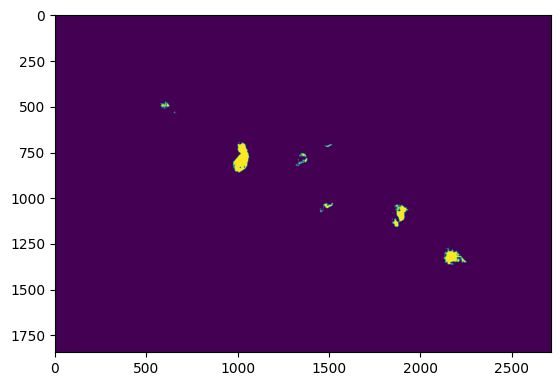

In [11]:
import matplotlib.pyplot as plt 

HE_id = list(crc_df[crc_df['images_id']==225441].HE_id)[0]
h5_file = h5py.File(h5_dir_path+(str(int(HE_id)))+'/path5_mask.h5', 'r')
plt.imshow(h5_file["wsi_masks"]['predicted_region_mask_l2_4'])

In [12]:
import openslide
import sys
sys.path.append('..')
slides_id_df = pd.read_csv('../get_data/data_sheets/image_id_res.csv')
concentriq_image_dir = '/concentriq/'
def print_level(image_path, magnification=20):
    slide = openslide.OpenSlide(image_path)
    level = slide.get_best_level_for_downsample(magnification)
    print(level)


for row in slides_id_df[slides_id_df['cancer']=='CRC'].iterrows():
    row=row[1]
    storageKey = row['storageKey']
    image_path = concentriq_image_dir+storageKey
    print_level(image_path)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
